In [31]:
!pip3 install -q --upgrade pip
!pip3 install -q pandas numpy matplotlib seaborn openpyxl climateserv requests netCDF4 xarray pyproj geopandas Fiona
!pip3 install -q GDAL==3.8.2

In [32]:
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd
from tqdm import tqdm

In [33]:
import pandas as pd

# Load your data
precipitation_df = pd.read_csv('../../data/processed_data/precipitation/combined_precipitation_data.csv')
monitoring_df = pd.read_csv('../../data/processed_data/igrac/igrac_gambia.csv')

In [34]:
monitoring_df.dtypes

ID                             object
Value                         float64
Date                           object
Day                             int64
Month                           int64
Year                            int64
Latitude                      float64
Longitude                     float64
Ground surface elevation      float64
LIS_Soil_Moisture_Combined    float64
dtype: object

In [35]:
precipitation_df.dtypes

time              object
longitude        float64
latitude         float64
precipitation    float64
dtype: object

In [36]:
# Convert 'Date' in monitoring_df to datetime and remove timezone if necessary
monitoring_df['Date'] = pd.to_datetime(monitoring_df['Date']).dt.tz_localize(None)

# Convert 'time' in precipitation_df to datetime
precipitation_df['time'] = pd.to_datetime(precipitation_df['time'])

# Create the BallTree using latitude and longitude from precipitation_df
tree = BallTree(np.radians(precipitation_df[['latitude', 'longitude']].values), metric='haversine')


In [37]:
# Function adjusted for debugging
def find_nearest_precipitation(row, tree, gdf_precip, time_threshold=pd.Timedelta('5 days')):
    lat_lon_rad = np.radians([[row.Latitude, row.Longitude]])
    spatial_index = tree.query(lat_lon_rad, k=1, return_distance=False)
    nearest_location = gdf_precip.iloc[spatial_index[0][0]]

    time_difference = abs(nearest_location['time'] - row.Date)
    if time_difference <= time_threshold:
        return nearest_location['precipitation'], nearest_location['time'], nearest_location['latitude'], nearest_location['longitude']
    else:
        # Debugging print statement
        print(f"No match within time threshold for row date: {row.Date}")
        return np.nan, nearest_location['time'], nearest_location['latitude'], nearest_location['longitude']

# Apply the function and store results in new columns
subset_df = monitoring_df.head(100).copy()  # Adjust the number as needed for the initial test
results = [find_nearest_precipitation(row, tree=tree, gdf_precip=precipitation_df) for row in tqdm(subset_df.itertuples(), total=len(subset_df))]

# Unpack results into separate columns
subset_df['nearest_precipitation'], subset_df['nearest_time'], subset_df['nearest_latitude'], subset_df['nearest_longitude'] = zip(*results)

# Display the result
subset_df

100%|██████████| 100/100 [00:00<00:00, 2829.65it/s]

No match within time threshold for row date: 2016-04-14 00:00:00
No match within time threshold for row date: 2015-12-26 00:00:00
No match within time threshold for row date: 2015-12-26 00:00:00
No match within time threshold for row date: 2015-12-25 00:00:00
No match within time threshold for row date: 2015-12-25 00:00:00
No match within time threshold for row date: 2015-12-25 00:00:00
No match within time threshold for row date: 2015-12-25 00:00:00
No match within time threshold for row date: 2015-12-24 00:00:00
No match within time threshold for row date: 2015-12-24 00:00:00
No match within time threshold for row date: 2015-12-24 00:00:00
No match within time threshold for row date: 2015-12-24 00:00:00
No match within time threshold for row date: 2015-12-23 00:00:00
No match within time threshold for row date: 2015-12-23 00:00:00
No match within time threshold for row date: 2015-12-23 00:00:00
No match within time threshold for row date: 2015-12-23 00:00:00
No match within time thre

,ID,Value,Date,Day,Month,Year,Latitude,Longitude,Ground surface elevation,LIS_Soil_Moisture_Combined,nearest_precipitation,nearest_time,nearest_latitude,nearest_longitude
0,NWP00001,14.26,2016-04-14,14,4,2016,13.420804,-16.716666,19.47,0.172124,NaN,2022-07-31,13.450002,-16.750004
1,NWP00001,13.82,2015-12-26,26,12,2015,13.420804,-16.716666,19.47,0.210837,NaN,2022-07-31,13.450002,-16.750004
2,NWP00001,13.83,2015-12-26,26,12,2015,13.420804,-16.716666,19.47,0.210837,NaN,2022-07-31,13.450002,-16.750004
3,NWP00001,13.82,2015-12-25,25,12,2015,13.420804,-16.716666,19.47,0.211614,NaN,2022-07-31,13.450002,-16.750004
4,NWP00001,13.82,2015-12-25,25,12,2015,13.420804,-16.716666,19.47,0.211614,NaN,2022-07-31,13.450002,-16.750004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NWP00001,13.93,2015-12-02,2,12,2015,13.420804,-16.716666,19.47,0.234772,NaN,2022-07-31,13.450002,-16.750004
96,NWP00001,13.93,2015-12-02,2,12,2015,13.420804,-16.716666,19.47,0.234772,NaN,2022-07-31,13.450002,-16.750004
97,NWP00001,13.93,2015-12-02,2,12,2015,13.420804,-16.716666,19.47,0.234772,NaN,2022-07-31,13.450002,-16.750004
98,NWP00001,13.93,2015-12-02,2,12,2015,13.420804,-16.716666,19.47,0.234772,NaN,2022-07-31,13.450002,-16.750004


In [22]:
# Apply the function and store results in new columns
subset_df = monitoring_df.head(100).copy()  # Adjust the number as needed for the initial test
results = [find_nearest_precipitation(row, tree=tree, gdf_precip=precipitation_df) for row in tqdm(subset_df.itertuples(), total=len(subset_df))]

# Unpack results into separate columns
subset_df['nearest_precipitation'], subset_df['nearest_time'], subset_df['nearest_latitude'], subset_df['nearest_longitude'] = zip(*results)

# Display the result
subset_df

100%|██████████| 100/100 [00:00<00:00, 2526.72it/s]


,ID,Value,Date,Day,Month,Year,Latitude,Longitude,Ground surface elevation,LIS_Soil_Moisture_Combined,nearest_precipitation,nearest_time,nearest_latitude,nearest_longitude
0,NWP00001,14.26,2016-04-14,14,4,2016,13.420804,-16.716666,19.47,0.172124,NaN,2022-07-31,13.450002,-16.750004
1,NWP00001,13.82,2015-12-26,26,12,2015,13.420804,-16.716666,19.47,0.210837,NaN,2022-07-31,13.450002,-16.750004
2,NWP00001,13.83,2015-12-26,26,12,2015,13.420804,-16.716666,19.47,0.210837,NaN,2022-07-31,13.450002,-16.750004
3,NWP00001,13.82,2015-12-25,25,12,2015,13.420804,-16.716666,19.47,0.211614,NaN,2022-07-31,13.450002,-16.750004
4,NWP00001,13.82,2015-12-25,25,12,2015,13.420804,-16.716666,19.47,0.211614,NaN,2022-07-31,13.450002,-16.750004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NWP00001,13.93,2015-12-02,2,12,2015,13.420804,-16.716666,19.47,0.234772,NaN,2022-07-31,13.450002,-16.750004
96,NWP00001,13.93,2015-12-02,2,12,2015,13.420804,-16.716666,19.47,0.234772,NaN,2022-07-31,13.450002,-16.750004
97,NWP00001,13.93,2015-12-02,2,12,2015,13.420804,-16.716666,19.47,0.234772,NaN,2022-07-31,13.450002,-16.750004
98,NWP00001,13.93,2015-12-02,2,12,2015,13.420804,-16.716666,19.47,0.234772,NaN,2022-07-31,13.450002,-16.750004


In [38]:
# Check the date range in monitoring_df
monitoring_date_range = monitoring_df['Date'].agg(['min', 'max'])
print(f"Monitoring Date Range: {monitoring_date_range['min']} to {monitoring_date_range['max']}")

# Check the date range in precipitation_df
precipitation_date_range = precipitation_df['time'].agg(['min', 'max'])
print(f"Precipitation Date Range: {precipitation_date_range['min']} to {precipitation_date_range['max']}")

# If the dates do not overlap, you will need to obtain precipitation data that covers the range of monitoring_df.
# If they do overlap, try increasing the time threshold to see if you can get any matches.


Monitoring Date Range: 2015-01-01 00:00:00 to 2022-07-23 00:00:00
Precipitation Date Range: 2015-01-03 00:00:00 to 2022-12-31 00:00:00


In [39]:
# Use a larger time threshold for debugging
time_threshold_debug = pd.Timedelta('365 days')

# Adjusted function for debugging with a larger time threshold
def find_nearest_precipitation_debug(row, tree, gdf_precip, time_threshold):
    lat_lon_rad = np.radians([[row.Latitude, row.Longitude]])
    spatial_index = tree.query(lat_lon_rad, k=1, return_distance=False)
    nearest_location = gdf_precip.iloc[spatial_index[0][0]]

    time_difference = abs(nearest_location['time'] - row.Date)
    if time_difference <= time_threshold:
        return nearest_location['precipitation'], nearest_location['time'], nearest_location['latitude'], nearest_location['longitude']
    else:
        return np.nan, nearest_location['time'], nearest_location['latitude'], nearest_location['longitude']

# Test with the larger time threshold
results_debug = [find_nearest_precipitation_debug(row, tree=tree, gdf_precip=precipitation_df, time_threshold=time_threshold_debug) for row in monitoring_df.itertuples()]


  0%|          | 0/100 [11:50<?, ?it/s]


In [40]:
results_debug

[(nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07-31 00:00:00'), 13.450002, -16.750004),
 (nan, Timestamp('2022-07

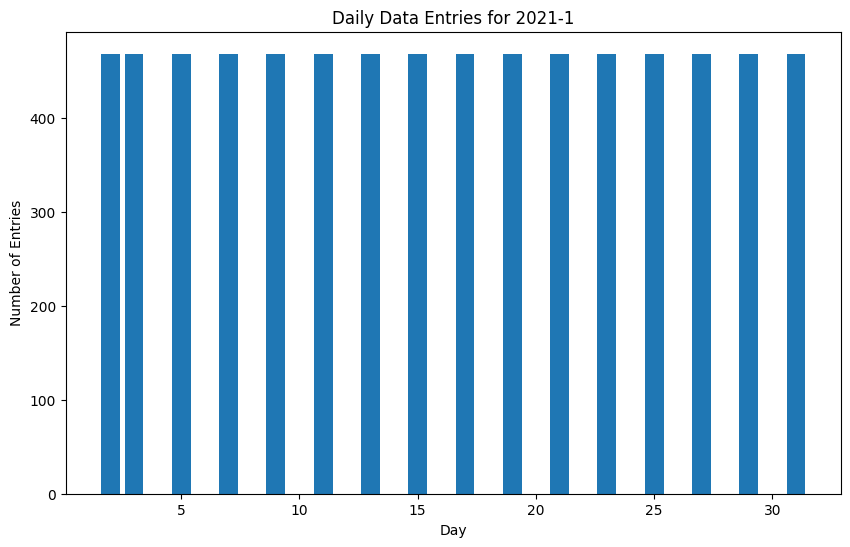

In [59]:
import matplotlib.pyplot as plt

# Example: Visualize data for January 2021
example_year = 2021
example_month = 1
monthly_data = daily_data_count_df[(daily_data_count_df['year'] == example_year) & (daily_data_count_df['month'] == example_month)]

plt.figure(figsize=(10, 6))
plt.bar(monthly_data['day'], monthly_data['count'])
plt.title(f'Daily Data Entries for {example_year}-{example_month}')
plt.xlabel('Day')
plt.ylabel('Number of Entries')
plt.show()
